In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# does the log-transform reintroduce cell size effects?

We tried a formal proof but got stuck on a rather difficult step. We will instead demonstrate what happens so that we get an intuition of what is going on.

In [2]:
adata = sc.datasets.pbmc3k()

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
sc.pp.filter_genes(adata, min_cells=5) #thanks Katrin
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [4]:
# raw total counts per cell:
raw_total = np.array(np.sum(adata.X, axis=1))[:, 0]

In [5]:
# normalised total counts per cell
sc.pp.normalize_total(adata, target_sum=None)
norm_total = np.array(np.sum(adata.X, axis=1))[:, 0]

In [6]:
# now log transform and see what happens!
sc.pp.log1p(adata)
log_total = np.array(np.sum(adata.X, axis=1))[:, 0]

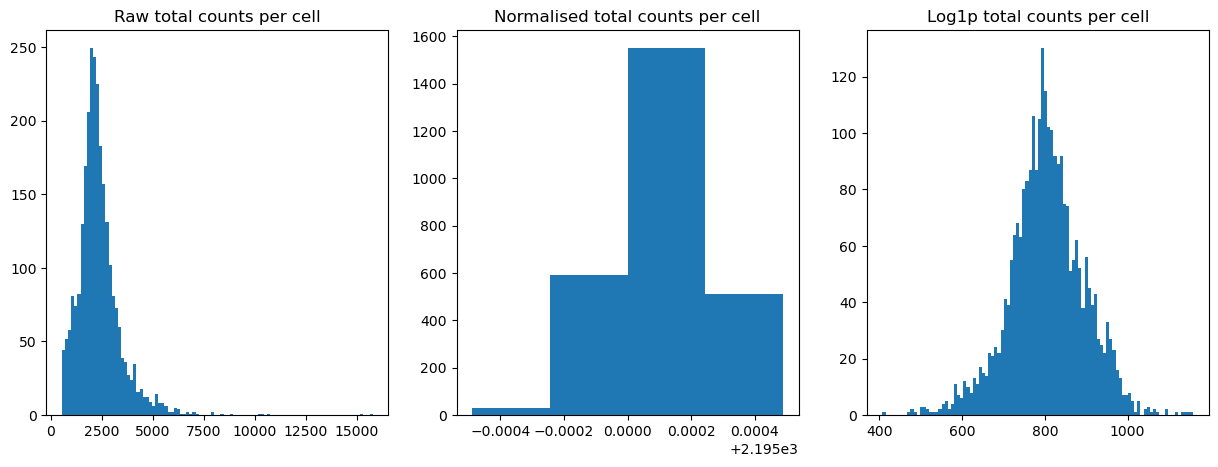

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].hist(raw_total, bins=100)
ax[0].set_title("Raw total counts per cell")
ax[1].hist(norm_total, bins=10)
ax[1].set_title("Normalised total counts per cell")
ax[2].hist(log_total, bins=100)
ax[2].set_title("Log1p total counts per cell");

Log-transforming will not affect each count the same: small counts will not be squished as much as large counts. This means that the sums of the log-transformed counts of each cell will no longer be equal. Generally, we need to remember that the sum of the logs is not the same as the log of the sum.

Let's see if the genes that were highly expressed before are still highly expressed now:

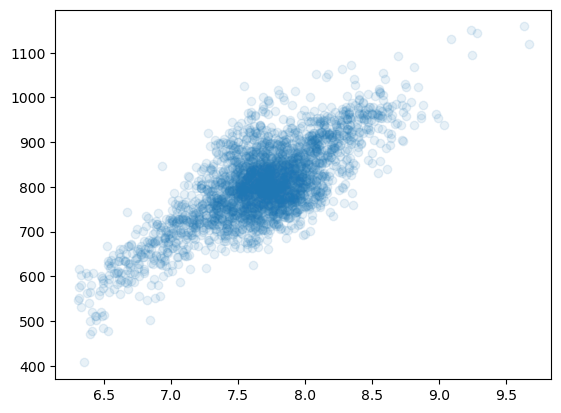

In [8]:
fig, ax = plt.subplots()
ax.scatter(np.log(raw_total), log_total, alpha=0.1)

they mostly are. This agrees with what we would expect.

# variable and anticorrelated genes

We took some time to read the documentation of the `sc.pp.highly_variable_genes` more carefully. We realised that it expects log-transformed counts. We then wanted to see if the default values that the function uses are reasonable or not.

In [9]:
# log(x) = 3
x = np.exp(3)
x

20.085536923187668

before blindly trusting whatever Scanpy is doing, let's first find out what this `sc.pp.highly_variable_genes` is _actually_ calculated on. We checked to see if the cutoffs for minimum and maximum average expression were reasonable.

In [10]:
avg_log1p_exp = np.array(np.mean(adata.X, axis=0))[0]

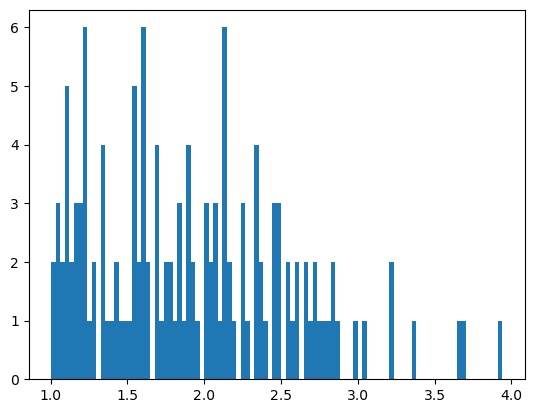

In [11]:
# let's plot Frankenstein space average expression
fig, ax = plt.subplots()
keep = avg_log1p_exp > 1
ax.hist(avg_log1p_exp[keep], bins=100);
# ax.vlines(x=0.0125, ymin=0, ymax=900, colors="red")

We had a look at the dispersion code to reverse-engineer how it is calculated, and we calculated it ourselves.

In [12]:
copyX = np.exp(adata.X.todense()) - 1
mean = np.array(np.mean(copyX, axis=0))[0]
var = np.array(np.var(copyX, axis=0))[0]

disp = var / mean

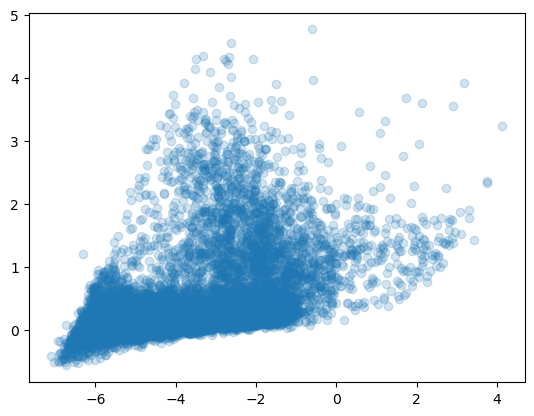

In [13]:
fig, ax = plt.subplots()
ax.scatter(np.log(mean), np.log(disp), alpha=0.2)

The dispersions mostly tell the same story as all other mean-variance plots: only genes with high average expression are overdispersed.

We then had a look to see how the dispersion values of the genes are distributed. We noticed that the distribution looks like it is slightly bimodal, with one peak around 0 and one peak around 1.something. We theorized that the peak around 0 are the non-informative genes, the ones with low variance, while the higher peak are the genes we are interested in.

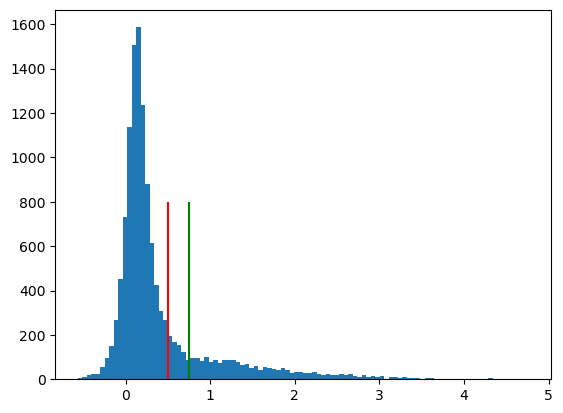

In [14]:
fig, ax = plt.subplots()
ax.hist(np.log(disp), bins=100);
ax.vlines(x=0.5, ymin=0, ymax=800, colors="red")
ax.vlines(x=0.75, ymin=0, ymax=800, colors="green")

In [15]:
sc.pp.highly_variable_genes(adata, min_disp=0.5, min_mean=0.0125, max_mean=3)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [16]:
adata.var

,gene_ids,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
index,,,,,,,,,,,,
AL627309.1,ENSG00000237683,9,9,0.003333,0.003328,99.666667,9.0,2.302585,False,0.002924,-0.082973,-0.737810
RP11-206L10.2,ENSG00000228327,5,5,0.001852,0.001850,99.814815,5.0,1.791759,False,0.001221,-0.189821,-0.917259
LINC00115,ENSG00000225880,18,18,0.006667,0.006645,99.333333,18.0,2.944439,False,0.005952,-0.057960,-0.695801
NOC2L,ENSG00000188976,258,258,0.106667,0.101352,90.444444,288.0,5.666427,False,0.094727,0.363677,0.012324
KLHL17,ENSG00000187961,9,9,0.003333,0.003328,99.666667,9.0,2.302585,False,0.003385,0.261069,-0.160002
...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,16,16,0.006667,0.006645,99.407407,18.0,2.944439,False,0.006010,0.262447,-0.157687
AL592183.1,ENSG00000220023,323,323,0.134815,0.126469,88.037037,364.0,5.899898,False,0.127270,0.352406,-0.006605
AL354822.1,ENSG00000215615,8,8,0.002963,0.002959,99.703704,8.0,2.197225,False,0.002622,0.266335,-0.151158


we checked whether we calculated the dispersions correctly:

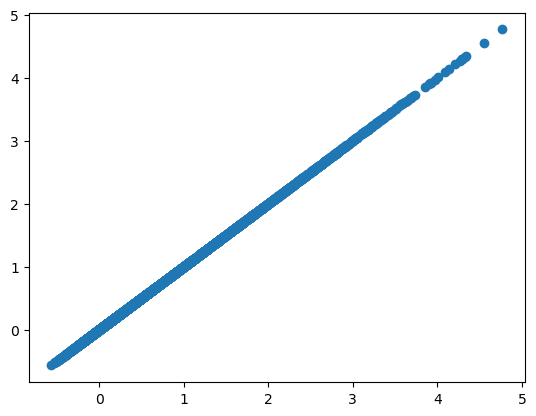

In [17]:
fig, ax = plt.subplots()
ax.scatter(np.log(disp), adata.var["dispersions"])

How many highly variable genes did we find?

In [18]:
adata.var["highly_variable"].sum()

1689

we subset the object to only highly variable genes and see if our medieval maps of the PBMC data improve at all:

In [19]:
adata_hv = adata[:, adata.var["highly_variable"]].copy()

In [20]:
sc.pp.neighbors(adata_hv, use_rep="X", metric="cosine")
sc.tl.umap(adata_hv)

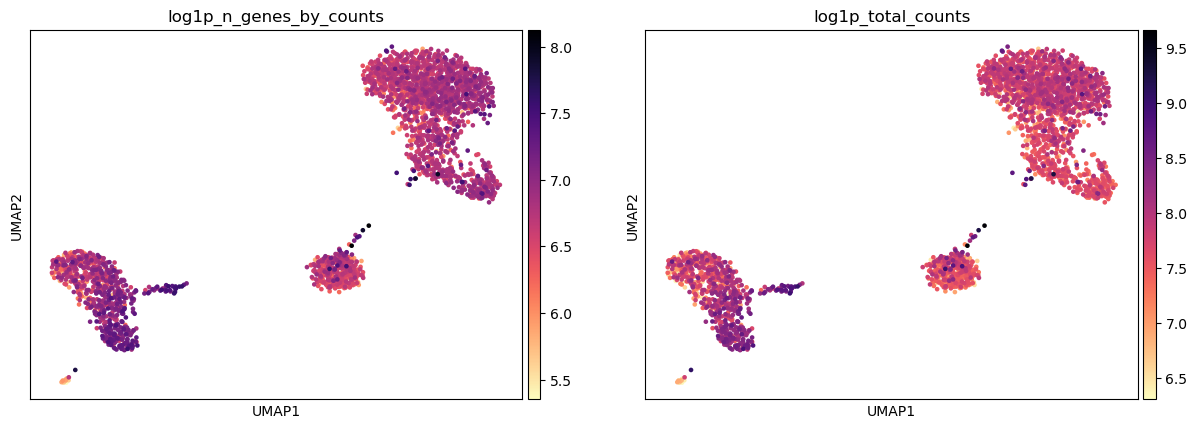

In [21]:
sc.pl.umap(adata_hv, color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

In the UMAP plots it looks like the effect of total counts is mostly gone. Does this mean that in subsetting to highly variable genes we somehow removed the effect of total counts? Let's have a look at the total size of the subsetted matrix and compare it to the original total counts:

In [22]:
current_total_size = np.array(np.sum(adata_hv.X, axis=1))[:, 0]

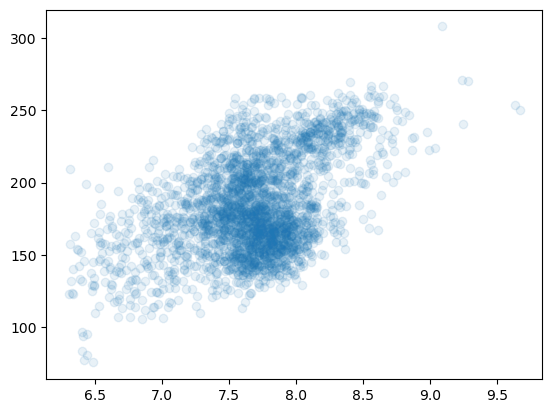

In [23]:
fig, ax = plt.subplots()
ax.scatter(adata.obs["log1p_total_counts"], current_total_size, alpha=0.1);

the effect is not completely gone, but it looks like many of the genes that are left (circle in the middle) do not contribute to the issue so much.